### Importing dependencies for the project

In [394]:
import zipfile as zip
import pandas as pd
import numpy as np
import tensorflow as tf
import PIL as pil
import rasterio as rio
import matplotlib as mpl

from rasterio.transform import xy
import matplotlib.pyplot as plt

### Global constants

In [395]:
RANDOM_STATE = 18022026
DATA_PATH = "Potsdam-GeoTif.zip"  # Path to the zipped data

# Step 1 - Dataset preparation

## Step 1.1 - Loading the data
In this step we will load the filename data from the zipped dataset into a pandas dataframe.

In [396]:
import zipfile
import pandas as pd

# Read the name of the files in the potsdam dataset and log them
# to a pandas df that we then can use to create splits of the data
with zip.ZipFile(DATA_PATH, "r") as z:
    file_paths = z.namelist()

# Remove the first entry and remove all prefixes
file_paths = sorted([fp for fp in file_paths[1:]])

# Create the pandas DF
file_path_df = pd.DataFrame({
    "file_path" : file_paths
})

# Display the DF
display(file_path_df.head())

,file_path
0,Potsdam-GeoTif/0000000224-0000028448.tif
1,Potsdam-GeoTif/0000000224-0000028672.tif
2,Potsdam-GeoTif/0000000224-0000028896.tif
3,Potsdam-GeoTif/0000000224-0000029120.tif
4,Potsdam-GeoTif/0000000224-0000029344.tif


## Step 1.2 - Create the 5 splits
In this step we will create a small splitter function for the dataset of indices in order to perform a split on the image dataset.

In [397]:
# The splitter
def df_splitter(df: pd.DataFrame, n, random_state):
    # Get the indices pf the dataframe
    indices = df.index.to_numpy(copy=True)
    # Shuffle them to ensure that the order does not matter    
    np.random.seed(random_state)
    np.random.shuffle(indices)
    # This function splits the array into n roughlt equal parts
    # this much nicer to use than the regular split which needs
    # the array to be divisible by n
    splits = np.array_split(indices, n)
    return splits

cv_splits = df_splitter(file_path_df,5,RANDOM_STATE)

# Step 1.3 - Looking at a sample image
In this step we will take a look at one sample image and display its different bands. The colorbar used in the images is automatically scaled to the values in the multi dimensional image array that it displays.The values in the 

--- Brief look at some samples of image data ---


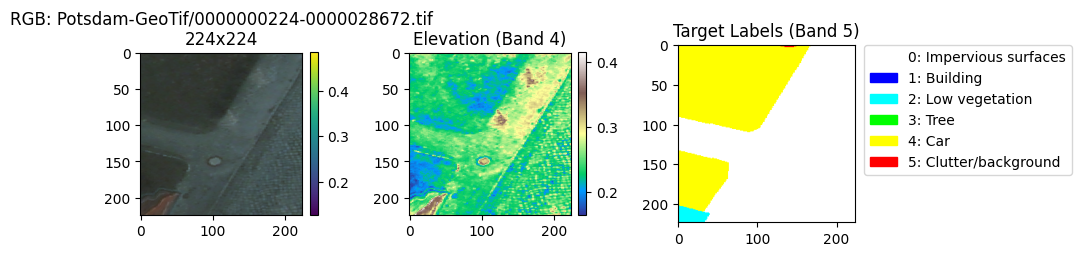

Path of sampled image:  Potsdam-GeoTif/0000000224-0000028672.tif
Array representation of raw image data:  (5, 224, 224)
Byte string of raw image data:  b'II*\x00\x08\x00\x00\x00\x14\x00' ... b'\xd5\x8d\xd8\xe5\x8e\xd8\xf2\xa7\x88\x08'


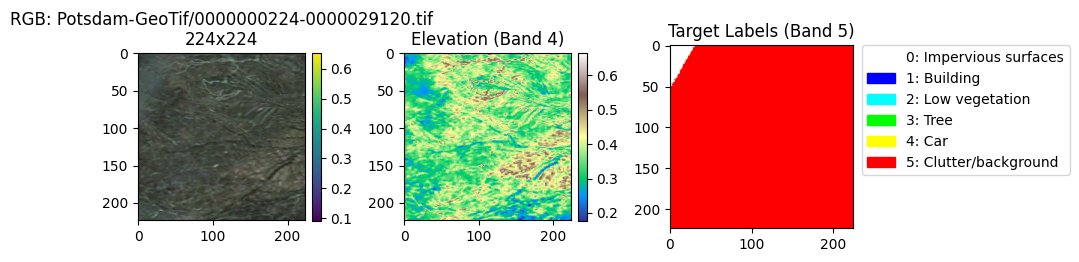

Path of sampled image:  Potsdam-GeoTif/0000000224-0000029120.tif
Array representation of raw image data:  (5, 224, 224)
Byte string of raw image data:  b'II*\x00\x08\x00\x00\x00\x14\x00' ... b'\xe7\xa4\xf5\x9e\xd3\xde|Gb\x02'


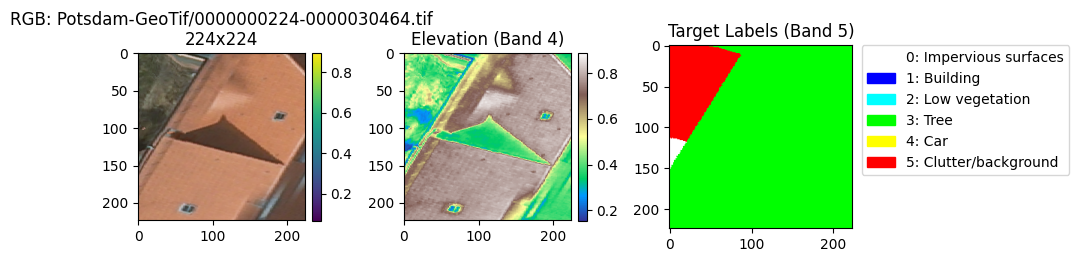

Path of sampled image:  Potsdam-GeoTif/0000000224-0000030464.tif
Array representation of raw image data:  (5, 224, 224)
Byte string of raw image data:  b'II*\x00\x08\x00\x00\x00\x14\x00' ... b'\xf6\xc6\xd9\xdb[one\xc2\x02'


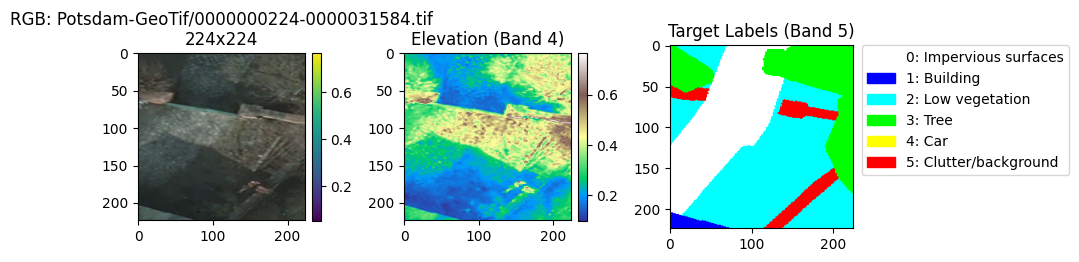

Path of sampled image:  Potsdam-GeoTif/0000000224-0000031584.tif
Array representation of raw image data:  (5, 224, 224)
Byte string of raw image data:  b'II*\x00\x08\x00\x00\x00\x14\x00' ... b'\xaf\x95\xf6\xbfW\xfb\x01@\x08\x08'


In [398]:
# A function that reads in data from a path and plots it using subplots.
def display_tif(path, title):
    # Code frome the Visualize_GeoTiff.ipynb notebook given in the assignment.
    img = rio.open(path)
    img_array = img.read()
    nRows = img_array.shape[1]
    nCols = img_array.shape[2]
    bands = img_array.shape[0]
    img_array = img_array.reshape(bands, nRows * nCols).T
    img_array = img_array.reshape(nRows, nCols, bands)

    # Pulling out different channels from the image and scaling the data.
    rgb_img_data = img_array[:, :, 0:3] / 255
    elevation_img_array = img_array[:, :, 3:4] / 255
    target_label_img_array = img_array[:, :, 5] / 255

    # Plotting the data.
    _, axes = plt.subplots(1, 3, figsize=(10, 3))
    # Plot 1: RGB Image
    im1 = axes[0].imshow(rgb_img_data)
    axes[0].set_title(f"RGB: {title}\n{nRows}x{nCols}")
    plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    # Plot 2: Elevation
    im2 = axes[1].imshow(elevation_img_array, cmap="terrain")
    axes[1].set_title("Elevation (Band 4)")
    plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

    # Plot 3: Target Labels, for this we also need to create a custom colormap
    class_names = [
        "Impervious surfaces", 
        "Building", 
        "Low vegetation", 
        "Tree", 
        "Car", 
        "Clutter/background"
    ]

    # Class Colors (Normalized RGB 0-1)
    class_colors = [
        (1.0, 1.0, 1.0),  # 0: Impervious surfaces (White)
        (0.0, 0.0, 1.0),  # 1: Building (Blue)
        (0.0, 1.0, 1.0),  # 2: Low vegetation (Cyan)
        (0.0, 1.0, 0.0),  # 3: Tree (Green)
        (1.0, 1.0, 0.0),  # 4: Car (Yellow)
        (1.0, 0.0, 0.0)   # 5: Clutter/background (Red)
    ]

    # Create the colormap
    cmap = mpl.colors.ListedColormap(class_colors)
    axes[2].imshow(target_label_img_array, cmap=cmap)
    axes[2].set_title("Target Labels (Band 5)")
    # Create legend patches
    patches = [
        mpl.patches.Patch(color=class_colors[i], label=f"{i}: {class_names[i]}") 
        for i in range(len(class_names))
    ]
    # Add legend outside the plot
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.tight_layout()
    plt.show()

# Lets first look at the data from a samples image.
print("--- Brief look at some samples of image data ---")
with zip.ZipFile(DATA_PATH, "r") as z:
    for i in [2,4,10,15]:
        sample_image_path = z.namelist()[i]
        with z.open(sample_image_path) as f:
            display_tif(f, sample_image_path)
            print("Path of sampled image: ", sample_image_path)
            img = rio.open(f)
            img_array = img.read()[0:5]
            # Set some print options ot not bloat the terminal output
            print("Array representation of raw image data: ", img_array.shape)
            raw_data = f.read()
            print("Byte string of raw image data: ", raw_data[0:10], "...", raw_data[-10:])

## Step 1.4 - Create TFRecord files
In this step we will create 5 TFRecord files and output them to the dir of this notebook.

In [399]:
# A function that turns the tif images into Example
# objects that can be serialized and written into the TFRecords file. Example is kind of
# unconvential name for something that is really just a row, sample or record.
def create_example(raw_tif_data, file_path):
    feature = {
        "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[raw_tif_data])),
        "filename": tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[file_path.encode("utf-8")])
        ),
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example

# Open the zipfile
print("\n--- Starting writing the splits to TFRecords ---")
with zip.ZipFile(DATA_PATH, "r") as z:
    # Iterate over every split
    for i, indices in enumerate(cv_splits):
        print(f"Processing split {i}")
        file_paths = file_path_df.iloc[indices]["file_path"].to_list()
        # Create a list of tuples (raw, filename)
        print(f"Extracting raw image information for split {i}")
        image_data = [(z.open(path).read(), path) for path in file_paths]
        # Create a TF records writer
        print(f"Writing raw image data to tfrecords for split {i}")
        with tf.io.TFRecordWriter(f"Potsdam-GeoTif-split-{i}.tfrecords") as writer:
            for raw_tif_data, file_path in image_data:
                example = create_example(raw_tif_data, file_path)
                serialized = example.SerializeToString()
                writer.write(serialized)


--- Starting writing the splits to TFRecords ---
Processing split 0
Extracting raw image information for split 0
Writing raw image data to tfrecords for split 0
Processing split 1
Extracting raw image information for split 1
Writing raw image data to tfrecords for split 1
Processing split 2
Extracting raw image information for split 2
Writing raw image data to tfrecords for split 2
Processing split 3
Extracting raw image information for split 3
Writing raw image data to tfrecords for split 3
Processing split 4
Extracting raw image information for split 4
Writing raw image data to tfrecords for split 4
